# Preprocessing
by Samskar

In [26]:
# === Imports ===
import os
from PIL import Image, ImageOps
import numpy as np
import cv2
import pandas as pd
import imagehash
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [10]:
# Define File Directories
BASE_DATA_DIR = "/kaggle/input/deepfashion2-original-with-dataframes/DeepFashion2"

PROCESSED_DATA_DIR = "/kaggle/working/processed"

TRAIN_IMAGES_DIR = os.path.join(BASE_DATA_DIR, 'deepfashion2_original_images', 'train', 'image')
VAL_IMAGES_DIR   = os.path.join(BASE_DATA_DIR, 'deepfashion2_original_images', 'validation', 'image')
TEST_IMAGES_DIR  = os.path.join(BASE_DATA_DIR, 'deepfashion2_original_images', 'test', 'test', 'image')

TRAIN_LABELS_PATH = os.path.join(BASE_DATA_DIR, 'img_info_dataframes', 'train.csv')
VAL_LABELS_PATH   = os.path.join(BASE_DATA_DIR, 'img_info_dataframes', 'validation.csv')
TEST_LABELS_PATH  = os.path.join(BASE_DATA_DIR, 'img_info_dataframes', 'test.csv')

# Create processed data folder in the Kaggle working directory
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

CSV Columns: Index(['path', 'segmentation', 'landmarks', 'b_box', 'category_id',
       'category_name', 'scale', 'viewpoint', 'occlusion', 'zoom_in',
       'img_height', 'img_width'],
      dtype='object')
Total training images: 191961
Total label entries in train CSV: 312186
Missing images referenced in labels: 0
category_name
short sleeve top        71645
trousers                55387
shorts                  36616
long sleeve top         36064
skirt                   30835
vest dress              17949
short sleeve dress      17211
vest                    16095
long sleeve outwear     13457
long sleeve dress        7907
sling dress              6492
sling                    1985
short sleeve outwear      543
Name: count, dtype: int64


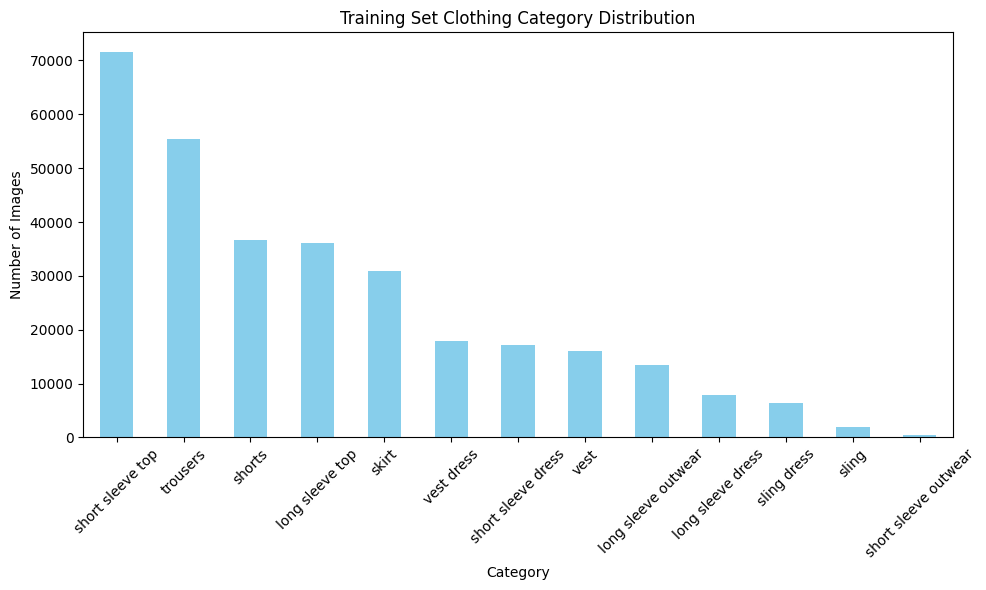

In [11]:
# --- Load train labels ---
labels_df = pd.read_csv(TRAIN_LABELS_PATH)
print("CSV Columns:", labels_df.columns)

# Ensure we extract just the filename from the 'path' column (works even if it's already just a filename)
if 'path' in labels_df.columns:
    labels_df['image_name'] = labels_df['path'].apply(lambda x: os.path.basename(str(x)))
else:
    # Fallback: maybe the CSV already has image names
    labels_df['image_name'] = labels_df['image_name']

# --- Dataset info ---
print(f"Total training images: {len(os.listdir(TRAIN_IMAGES_DIR))}")
print(f"Total label entries in train CSV: {len(labels_df)}")

# --- Check for missing images ---
missing_images = [img for img in labels_df['image_name'] 
                  if not os.path.exists(os.path.join(TRAIN_IMAGES_DIR, img))]
print(f"Missing images referenced in labels: {len(missing_images)}")

# --- Category distribution ---
category_col = 'category_name'  # make sure this matches your CSV exactly
category_counts = labels_df[category_col].value_counts()
print(category_counts)

# --- Plot ---
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Clothing Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
image_sizes = []
corrupted_images = []

for img_name in os.listdir(TRAIN_IMAGES_DIR):
    img_path = os.path.join(TRAIN_IMAGES_DIR, img_name)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
    except Exception:
        corrupted_images.append(img_name)

print(f"Corrupted or unreadable images: {len(corrupted_images)}")

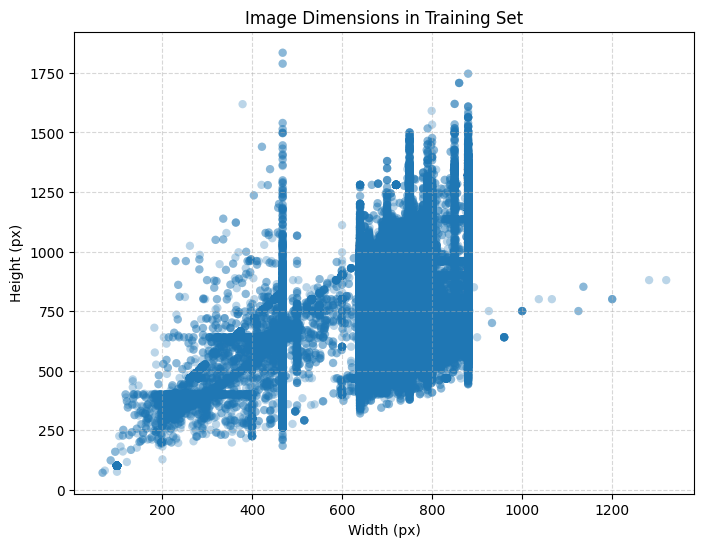

In [12]:
# Check that columns exist
if 'img_width' in labels_df.columns and 'img_height' in labels_df.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(labels_df['img_width'], labels_df['img_height'], alpha=0.3, edgecolors='none')
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.title('Image Dimensions in Training Set')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("CSV does not contain 'img_width' and 'img_height' columns.")

In [13]:
def is_blurry(image_path, threshold=100):
    """Detect blurry images using Laplacian variance."""
    img = cv2.imread(image_path)
    if img is None:
        return True  # Treat unreadable as blurry to remove
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var < threshold

def resize_with_padding(img, desired_size=640):
    """Resize with aspect ratio preserved and pad to desired size."""
    old_size = img.size  # (width, height)
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, Image.ANTIALIAS)

    new_img = Image.new("RGB", (desired_size, desired_size), (0, 0, 0))  # explicit background color black
    paste_position = ((desired_size - new_size[0]) // 2, (desired_size - new_size[1]) // 2)
    new_img.paste(img, paste_position)
    return new_img

def is_duplicate(img_path, hash_set, hash_size=8):
    """Detect duplicate images using perceptual hashing."""
    try:
        img = Image.open(img_path)
        phash = imagehash.phash(img, hash_size=hash_size)
    except Exception:
        return True  # If can’t open, treat as duplicate to remove
    if phash in hash_set:
        return True
    else:
        hash_set.add(phash)
        return False

In [15]:
# === Main Preprocessing Loop ===
log = []
hash_set = set()

raw_images = os.listdir(BASE_DATA_DIR)

for img_name in raw_images:
    raw_path = os.path.join(BASE_DATA_DIR, img_name)
    processed_path = os.path.join(PROCESSED_DATA_DIR, img_name)

    try:
        # Step 1: Blur check
        if is_blurry(raw_path):
            log.append({'image': img_name, 'status': 'removed_blurry'})
            continue

        # Step 2: Duplicate check
        if is_duplicate(raw_path, hash_set):
            log.append({'image': img_name, 'status': 'removed_duplicate'})
            continue

        # Step 3: Open and preprocess image
        with Image.open(raw_path) as img:
            original_size = img.size
            
            # Smart resize + padding
            img_processed = resize_with_padding(img, desired_size=640)
            new_size = img_processed.size
            
            # Save processed image
            img_processed.save(processed_path)

            # Log success with sizes
            log.append({'image': img_name,
                        'original_size': original_size,
                        'new_size': new_size,
                        'status': 'processed'})

    except Exception as e:
        log.append({'image': img_name, 'status': f'error: {e}'})

In [16]:
# Save log to CSV
df_log = pd.DataFrame(log)
df_log.to_csv(os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_eda_log.csv'), index=False)
print("Preprocessing complete. Log saved.")

Preprocessing complete. Log saved.


In [19]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

# --- Load full training labels CSV ---
labels_df = pd.read_csv(TRAIN_LABELS_PATH)

# --- Label Mapping ---
category_map = {
    'short sleeve top': 'top',
    'long sleeve top': 'top',
    'shorts': 'bottom',
    'trousers': 'bottom',
    'skirt': 'bottom',
    'vest dress': 'dress',
    'short sleeve dress': 'dress',
    'long sleeve outwear': 'outerwear',
    'long sleeve dress': 'dress',
    'sling dress': 'dress',
    'vest': 'top',
    'sling': 'top',
    'short sleeve outwear': 'outerwear',
}
labels_df['category_mapped'] = labels_df['category_name'].map(category_map).fillna('other')

print("Mapped category distribution:")
print(labels_df['category_mapped'].value_counts())

Mapped category distribution:
category_mapped
top          125789
bottom       122838
dress         49559
outerwear     14000
Name: count, dtype: int64


In [20]:
# --- Split into train and validation sets (stratified) ---
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['category_mapped'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# --- Save split CSVs for later use ---
train_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_train_labels.csv'), index=False)
val_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_val_labels.csv'), index=False)


Training samples: 249748
Validation samples: 62438


In [21]:
# --- Define augmentation transforms (to use in training script) ---
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [22]:
# Save clean image paths CSVs for easier loading ---
train_image_paths = [os.path.basename(p) for p in train_df['path']]
val_image_paths = [os.path.basename(p) for p in val_df['path']]

pd.DataFrame({'image_name': train_image_paths, 'category': train_df['category_mapped']}).to_csv(
    os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_train_images.csv'), index=False)

pd.DataFrame({'image_name': val_image_paths, 'category': val_df['category_mapped']}).to_csv(
    os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_val_images.csv'), index=False)

print("Train/Validation splits created and saved. Augmentation pipeline ready.")

Train/Validation splits created and saved. Augmentation pipeline ready.


In [24]:
class DeepFashion2Dataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_name']
        label = self.df.iloc[idx]['category']

        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Encode label as integer if needed, or keep string for now
        return image, label

In [25]:
train_dataset = DeepFashion2Dataset(
    csv_file=os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_train_images.csv'),
    images_dir=PROCESSED_DATA_DIR,  # Your processed images are saved here
    transform=train_transforms
)

val_dataset = DeepFashion2Dataset(
    csv_file=os.path.join(PROCESSED_DATA_DIR, 'deepfashion2_val_images.csv'),
    images_dir=PROCESSED_DATA_DIR,
    transform=val_transforms
)

In [27]:
# Map categories to integer indices
category_to_idx = {cat: i for i, cat in enumerate(train_dataset.df['category'].unique())}
train_dataset.df['label_idx'] = train_dataset.df['category'].map(category_to_idx)

# Compute weights inversely proportional to class frequency
class_counts = train_dataset.df['label_idx'].value_counts().sort_index()
class_weights = 1. / class_counts
samples_weights = train_dataset.df['label_idx'].map(class_weights).values

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

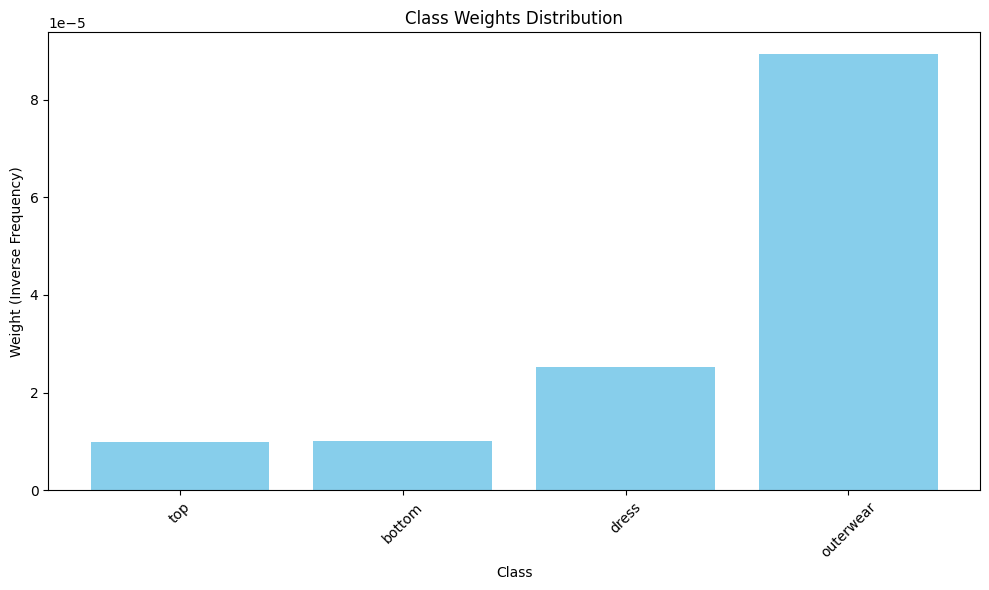

Class: top, Weight: 0.00000994
Class: bottom, Weight: 0.00001018
Class: dress, Weight: 0.00002522
Class: outerwear, Weight: 0.00008929


In [28]:
# Map index to category name for plotting
idx_to_category = {v: k for k, v in category_to_idx.items()}

# Extract weights in the order of categories
weights_per_class = class_weights.sort_index().values
categories = [idx_to_category[i] for i in range(len(weights_per_class))]

plt.figure(figsize=(10,6))
plt.bar(categories, weights_per_class, color='skyblue')
plt.title('Class Weights Distribution')
plt.xlabel('Class')
plt.ylabel('Weight (Inverse Frequency)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print the weights
for cat, w in zip(categories, weights_per_class):
    print(f"Class: {cat}, Weight: {w:.8f}")

Class distribution and computed weights:
Class: top        | Index: 0 | Count: 100631 | Weight: 0.000010
Class: bottom     | Index: 1 | Count:  98270 | Weight: 0.000010
Class: dress      | Index: 2 | Count:  39647 | Weight: 0.000025
Class: outerwear  | Index: 3 | Count:  11200 | Weight: 0.000089


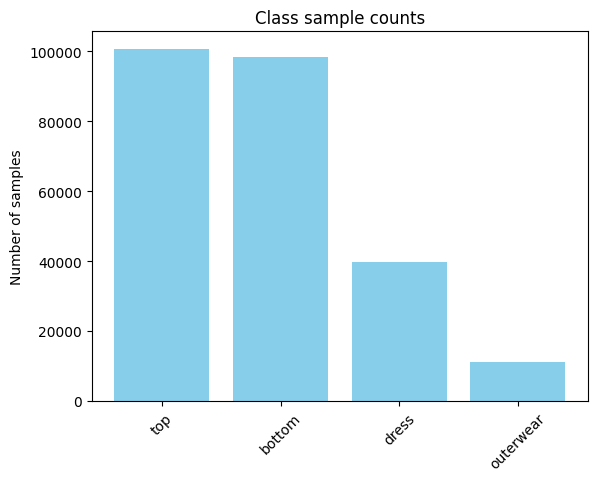

In [29]:
print("Class distribution and computed weights:")
for cat, idx in category_to_idx.items():
    count = class_counts.get(idx, 0)
    weight = class_weights.get(idx, 0)
    print(f"Class: {cat:10s} | Index: {idx} | Count: {count:6d} | Weight: {weight:.6f}")


plt.bar(category_to_idx.keys(), class_counts.values, color='skyblue')
plt.title("Class sample counts")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()



In [30]:
sampled_indices = list(sampler)
sampled_labels = train_dataset.df.iloc[sampled_indices]['label_idx']
unique, counts = np.unique(sampled_labels, return_counts=True)
for u, c in zip(unique, counts):
    cat_name = list(category_to_idx.keys())[list(category_to_idx.values()).index(u)]
    print(f"Sampled class {cat_name}: {c} samples ({c/len(sampled_labels)*100:.2f}%)")


Sampled class top: 62349 samples (24.96%)
Sampled class bottom: 62434 samples (25.00%)
Sampled class dress: 62566 samples (25.05%)
Sampled class outerwear: 62399 samples (24.98%)


# Training Yolo Model
by Nathan